In [236]:
import os, sys
import numpy as np
import ants
import argparse
import shutil
import logging
import subprocess
import tqdm
import matplotlib.pyplot as plt 
import torchio as tio
from glob2 import glob
import json

In [237]:
save_dir = '/anvar/public_datasets/preproc_study/gbm/6_hist/6_hist_fold_1/'
base_dir = '/anvar/public_datasets/preproc_study/gbm/4a_resamp/'
patients = os.listdir(save_dir)

In [456]:
i = 80
t1_image = tio.Subject(t1 = tio.ScalarImage(base_dir + patients[i] + '/CT1.nii.gz'))
t2_image = tio.Subject(t1 = tio.ScalarImage(base_dir + patients[i] + '/FLAIR.nii.gz'))
mask_path = '/anvar/public_datasets/preproc_study/gbm/5_ss_shared/' + patients[i] + '/CT1_mask.nii.gz'
mask = tio.Subject(mask = tio.ScalarImage(mask_path))

In [431]:
t1_landmarks = HistogramStandardization.train([base_dir + patients[i] + '/CT1.nii.gz'])
t2_landmarks = HistogramStandardization.train([base_dir + patients[i] + '/FLAIR.nii.gz'])

100%|██████████| 1/1 [00:00<00:00,  1.81it/s]


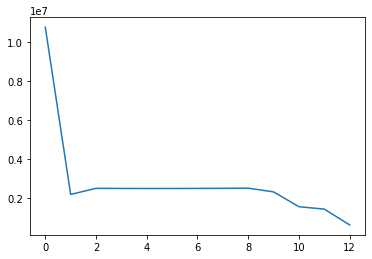

In [307]:
# ненулевые лажа
img_nonzero = np.nonzero(t1_image['t1'].numpy())
plt.plot(np.histogram(img_nonzero, bins = 13)[0])

In [308]:
def _get_percentiles(percentiles_cutoff):
    quartiles = np.arange(25, 100, 25).tolist()
    deciles = np.arange(10, 100, 10).tolist()
    all_percentiles = list(percentiles_cutoff) + quartiles + deciles
    percentiles = sorted(set(all_percentiles))
    return np.array(percentiles)

In [309]:
DEFAULT_CUTOFF = 0.01, 0.99
quantiles_cutoff = DEFAULT_CUTOFF 
percentiles_cutoff = 100 * np.array(quantiles_cutoff)
percentiles_database = []
a, b = percentiles_cutoff  # for mypy
percentiles = _get_percentiles((a, b))

In [310]:
percentiles

array([ 1., 10., 20., 25., 30., 40., 50., 60., 70., 75., 80., 90., 99.])

In [387]:
percentile_values = np.percentile(t1_image['t1'].numpy(), percentiles)

In [388]:
percentile_values

array([   0.        ,    0.        ,    0.        ,   97.83810806,
        121.13774948,  146.29317627,  170.9030304 ,  209.69428406,
        380.30928955, 1383.31924438, 2607.06738281, 3827.5269043 ,
       8046.86623535])

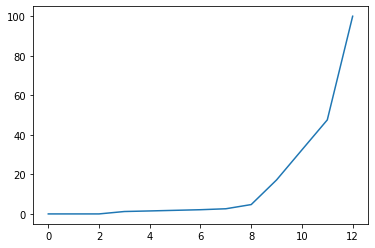

In [389]:
# ok here we are
plt.plot(percentile_values/percentile_values.max()*100)

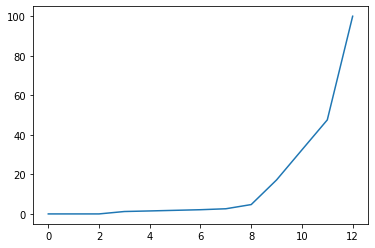

In [313]:
plt.plot(t1_landmarks)

In [314]:
import torch
from pathlib import Path
from typing import Callable
from typing import Dict
from typing import Optional
from typing import Sequence
from typing import Tuple
from typing import Union

def _normalize(
        tensor: torch.Tensor,
        landmarks: np.ndarray,
        mask: Optional[np.ndarray],
        cutoff: Optional= None,
        epsilon: float = 1e-5,
) -> torch.Tensor:
    cutoff_ = DEFAULT_CUTOFF if cutoff is None else cutoff
    array = tensor.numpy()
    mapping = landmarks

    data = array
    shape = data.shape
    data = data.reshape(-1).astype(np.float32)

    if mask is None:
        mask = np.ones_like(data, bool)
    mask = mask.reshape(-1)

    range_to_use = [0, 1, 2, 4, 5, 6, 7, 8, 10, 11, 12]

    quantiles_cutoff = _standardize_cutoff(cutoff_)
    percentiles_cutoff = 100 * np.array(quantiles_cutoff)
    a, b = percentiles_cutoff  # for mypy
    percentiles = _get_percentiles((a, b))
    percentile_values = np.percentile(data[mask], percentiles)

    # Apply linear histogram standardization
    range_mapping = mapping[range_to_use]
    range_perc = percentile_values[range_to_use]
    diff_mapping = np.diff(range_mapping)
    diff_perc = np.diff(range_perc)

    # Handling the case where two landmarks are the same
    # for a given input image. This usually happens when
    # image background is not removed from the image.
    diff_perc[diff_perc < epsilon] = np.inf

    affine_map = np.zeros([2, len(range_to_use) - 1])

    # Compute slopes of the linear models
    affine_map[0] = diff_mapping / diff_perc

    # Compute intercepts of the linear models
    affine_map[1] = range_mapping[:-1] - affine_map[0] * range_perc[:-1]

    bin_id = np.digitize(data, range_perc[1:-1], right=False)
    lin_img = affine_map[0, bin_id]
    aff_img = affine_map[1, bin_id]
    new_img = lin_img * data + aff_img
    new_img = new_img.reshape(shape)
    new_img = new_img.astype(np.float32)
    new_img = torch.as_tensor(new_img)
    return new_img

In [315]:
def _standardize_cutoff(cutoff: Sequence[float]) -> np.ndarray:
    """Standardize the cutoff values given in the configuration.

    Computes percentile landmark normalization by default.

    """
    cutoff_array = np.asarray(cutoff)
    cutoff_array[0] = max(0, cutoff_array[0])
    cutoff_array[1] = min(1, cutoff_array[1])
    cutoff_array[0] = np.min([cutoff_array[0], 0.09])
    cutoff_array[1] = np.max([cutoff_array[1], 0.91])
    return cutoff_array

In [316]:
t2_normalized = _normalize(
        tensor= torch.from_numpy(t2_image['t2'].numpy()),
        landmarks= percentile_values/percentile_values.max()*100,
        mask = None
)

In [ ]:
# -> не величины персентилей, а гистограмы к персентилям (по 12 бинам)
# рисовать гистограму ориринальную, тагретную и преобразование.
# посмотреть на работу на которую он ссылается
# 11.00 +

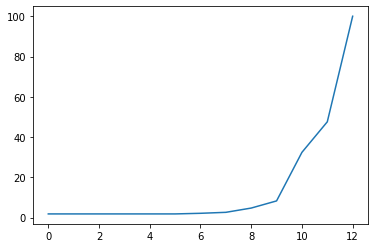

In [317]:
percentile_values = np.percentile(t2_normalized, percentiles)
plt.plot(percentile_values/percentile_values.max()*100)

In [331]:
landmarks_dict = {'t1': t1_landmarks}
hist_standardize = tio.HistogramStandardization(landmarks_dict)
t2_normed = hist_standardize(t2_image)

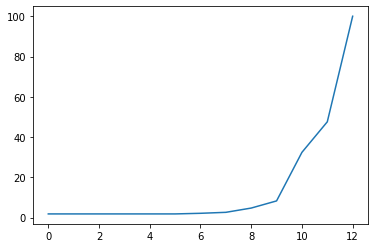

In [333]:
percentile_values = np.percentile(t2_normed['t1'], percentiles)
plt.plot(percentile_values/percentile_values.max()*100)

### Okey I am doing smth. Now the histograms:

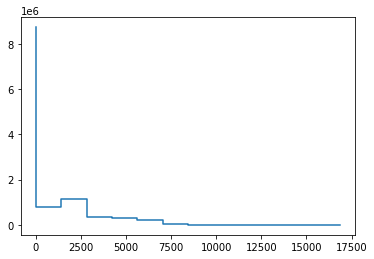

In [415]:
t1_hist, t1_hist_bins = np.histogram(t1_image['t1'].numpy().reshape(-1), bins=13)
plt.plot(t1_hist_bins[:-1], t1_hist, '-', drawstyle='steps')

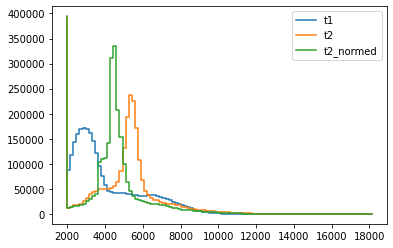

In [464]:
# t1 
mask = t1_image['t1'].numpy()>2000
masked_img = t1_image['t1'].numpy()[mask]
bins = 100 
t1_hist, t1_hist_bins = np.histogram(masked_img.reshape(-1), bins=bins)
plt.plot(t1_hist_bins[:-1], t1_hist, '-', drawstyle='steps', label ='t1')

# t2
masked_img = t2_image['t1'].numpy()[mask]
t1_hist, _ = np.histogram(masked_img.reshape(-1), bins=bins)
plt.plot(t1_hist_bins[:-1], t1_hist, '-', drawstyle='steps', label ='t2')

# t2_normed
masked_img = t2_normed['t1'].numpy()[mask]
t1_hist, _ = np.histogram(masked_img.reshape(-1), bins=bins)
plt.plot(t1_hist_bins[:-1], t1_hist, '-', drawstyle='steps', label ='t2_normed')
plt.legend();

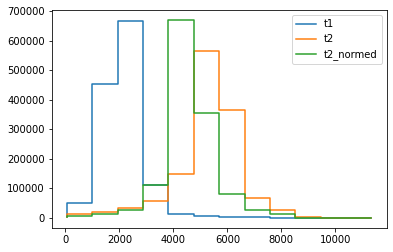

In [436]:
# t1 
masked_img = t1_image['t1'].numpy()[mask['mask'].numpy().astype(bool)]
t1_hist, t1_hist_bins = np.histogram(masked_img.reshape(-1), bins=13)
plt.plot(t1_hist_bins[:-1], t1_hist, '-', drawstyle='steps', label ='t1')

# t2
masked_img = t2_image['t1'].numpy()[mask['mask'].numpy().astype(bool)]
t1_hist, _ = np.histogram(masked_img.reshape(-1), bins=13)
plt.plot(t1_hist_bins[:-1], t1_hist, '-', drawstyle='steps', label ='t2')

# t2_normed
masked_img = t2_normed['t1'].numpy()[mask['mask'].numpy().astype(bool)]
t1_hist, _ = np.histogram(masked_img.reshape(-1), bins=13)
plt.plot(t1_hist_bins[:-1], t1_hist, '-', drawstyle='steps', label ='t2_normed')
plt.legend();

In [432]:
landmarks_dict = {'t1': t2_landmarks}
hist_standardize = tio.HistogramStandardization(landmarks_dict)
t1_normed = hist_standardize(t1_image)

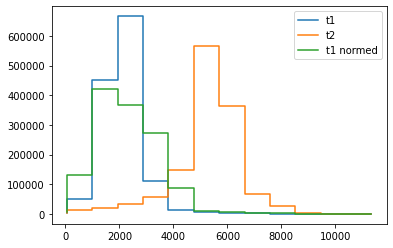

In [439]:
# t1 
masked_img = t1_image['t1'].numpy()[mask['mask'].numpy().astype(bool)]
t1_hist, t1_hist_bins = np.histogram(masked_img.reshape(-1), bins=13)
plt.plot(t1_hist_bins[:-1], t1_hist, '-', drawstyle='steps', label ='t1')

# t2
masked_img = t2_image['t1'].numpy()[mask['mask'].numpy().astype(bool)]
t1_hist, _ = np.histogram(masked_img.reshape(-1), bins=13)
plt.plot(t1_hist_bins[:-1], t1_hist, '-', drawstyle='steps', label ='t2')

# t1 normed
masked_img = t1_normed['t1'].numpy()[mask['mask'].numpy().astype(bool)]
t1_hist, _ = np.histogram(masked_img.reshape(-1), bins=13)
plt.plot(t1_hist_bins[:-1], t1_hist, '-', drawstyle='steps', label ='t1 normed')
plt.legend();

### Ok, scimage

In [444]:
t1_image['t1'].numpy().shape

(1, 250, 250, 186)

In [445]:
from skimage import exposure
from skimage.exposure import match_histograms
t1_matched_scimage = match_histograms(t1_image['t1'].numpy().reshape(-1), 
                                      t2_image['t1'].numpy().reshape(-1))
t1_matched_scimage = t1_matched_scimage.reshape((1, 250, 250, 186))

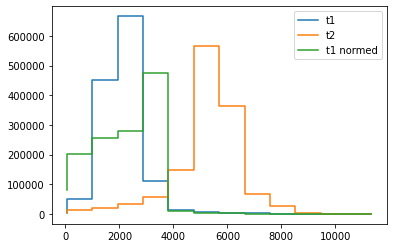

In [446]:
# t1 
masked_img = t1_image['t1'].numpy()[mask['mask'].numpy().astype(bool)]
t1_hist, t1_hist_bins = np.histogram(masked_img.reshape(-1), bins=13)
plt.plot(t1_hist_bins[:-1], t1_hist, '-', drawstyle='steps', label ='t1')

# t2
masked_img = t2_image['t1'].numpy()[mask['mask'].numpy().astype(bool)]
t1_hist, _ = np.histogram(masked_img.reshape(-1), bins=13)
plt.plot(t1_hist_bins[:-1], t1_hist, '-', drawstyle='steps', label ='t2')

# t1 normed
masked_img = t1_matched_scimage[mask['mask'].numpy().astype(bool)]
t1_hist, _ = np.histogram(masked_img.reshape(-1), bins=13)
plt.plot(t1_hist_bins[:-1], t1_hist, '-', drawstyle='steps', label ='t1 normed')
plt.legend();

### ok torchio histogram with mask

In [497]:
t1_image_2 = tio.Subject(t1 = tio.ScalarImage(base_dir + patients[81] + '/CT1.nii.gz'))
mask_path_2 = '/anvar/public_datasets/preproc_study/gbm/5_ss_shared/' + patients[81] + '/CT1_mask.nii.gz'

t1_image_1 = tio.Subject(t1 = tio.ScalarImage(base_dir + patients[80] + '/CT1.nii.gz'))
mask_path_1 = '/anvar/public_datasets/preproc_study/gbm/5_ss_shared/' + patients[80] + '/CT1_mask.nii.gz'

In [498]:
t1_landmarks = HistogramStandardization.train([base_dir + patients[i] + '/CT1.nii.gz'],
                                             mask_path = [mask_path_1])
t2_landmarks = HistogramStandardization.train([base_dir + patients[81] + '/CT1.nii.gz'],
                                             mask_path = [mask_path_2])

100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


In [499]:
landmarks_dict = {'t1': t2_landmarks}
hist_standardize = tio.HistogramStandardization(landmarks_dict)
t1_normed_1 = hist_standardize(t1_image_1)

In [506]:
mask_path_2 = '/anvar/public_datasets/preproc_study/gbm/5_ss_shared/' + patients[81] + '/CT1_mask.nii.gz'
mask_2 = tio.Subject(mask = tio.ScalarImage(mask_path_2))
mask_path_1 = '/anvar/public_datasets/preproc_study/gbm/5_ss_shared/' + patients[80] + '/CT1_mask.nii.gz'
mask_1 = tio.Subject(mask = tio.ScalarImage(mask_path_1))

In [507]:
mask_2.shape, t1_image_2.shape, mask_1.shape, t1_image_1.shape, 

((1, 260, 260, 186),
 (1, 260, 260, 186),
 (1, 250, 250, 186),
 (1, 250, 250, 186))

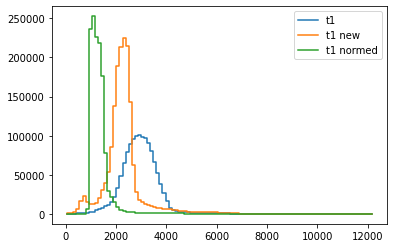

In [511]:
# t1 
masked_img = t1_image_1['t1'].numpy()[mask_1['mask'].numpy().astype(bool)]
t1_hist, t1_hist_bins = np.histogram(masked_img.reshape(-1), bins=100)
plt.plot(t1_hist_bins[:-1], t1_hist, '-', drawstyle='steps', label ='t1')

# t2
masked_img = t1_image_2['t1'].numpy()[mask_2['mask'].numpy().astype(bool)]
t1_hist, _ = np.histogram(masked_img.reshape(-1), bins=100)
plt.plot(t1_hist_bins[:-1], t1_hist, '-', drawstyle='steps', label ='t1 new')

# t1 normed
masked_img = t1_normed_1['t1'].numpy()[mask_1['mask'].numpy().astype(bool)]
t1_hist, _ = np.histogram(masked_img.reshape(-1), bins=100)
plt.plot(t1_hist_bins[:-1], t1_hist, '-', drawstyle='steps', label ='t1 normed')
plt.legend();

#### Ok ITK Snap

In [517]:
from skimage import exposure
from skimage.exposure import match_histograms
t1_matched_scimage = match_histograms(t1_image_2['t1'].numpy().reshape(-1), 
                                      t1_image_1['t1'].numpy().reshape(-1))
t1_matched_scimage = t1_matched_scimage.reshape(t1_image_2['t1'].numpy().shape)

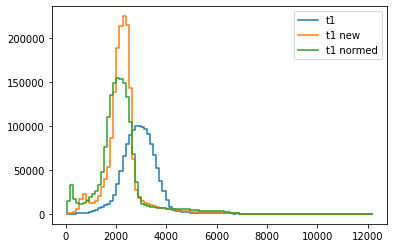

In [520]:
# t1 
masked_img = t1_image_1['t1'].numpy()[mask_1['mask'].numpy().astype(bool)]
t1_hist, t1_hist_bins = np.histogram(masked_img.reshape(-1), bins=100)
plt.plot(t1_hist_bins[:-1], t1_hist, '-', drawstyle='steps', label ='t1')

# t2
masked_img = t1_image_2['t1'].numpy()[mask_2['mask'].numpy().astype(bool)]
t1_hist, _ = np.histogram(masked_img.reshape(-1), bins=100)
plt.plot(t1_hist_bins[:-1], t1_hist, '-', drawstyle='steps', label ='t1 new')

# t1 normed
masked_img = t1_matched_scimage[mask_2['mask'].numpy().astype(bool)]
t1_hist, _ = np.histogram(masked_img.reshape(-1), bins=100)
plt.plot(t1_hist_bins[:-1], t1_hist, '-', drawstyle='steps', label ='t1 normed')
plt.legend();

In [523]:
t1_image_1['t1'].numpy()[:,:,100].shape

(1, 250, 186)

In [538]:
match_histograms?

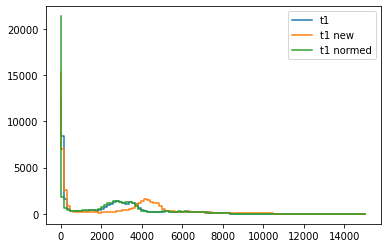

In [528]:
t1_matched_scimage = match_histograms(t1_image_2['t1'].numpy()[:,:,100].reshape(-1),
                                      t1_image_1['t1'].numpy()[:,:,100].reshape(-1))

# t1 

masked_img = t1_image_1['t1'].numpy()[:,:,100].reshape(-1)
t1_hist, t1_hist_bins = np.histogram(masked_img, bins=100)
plt.plot(t1_hist_bins[:-1], t1_hist, '-', drawstyle='steps', label ='t1')

# t2
masked_img = t1_image_2['t1'].numpy()[:,:,100].reshape(-1)
t1_hist, _ = np.histogram(masked_img, bins=100)
plt.plot(t1_hist_bins[:-1], t1_hist, '-', drawstyle='steps', label ='t1 new')

# t1 normed
masked_img = t1_matched_scimage
t1_hist, _ = np.histogram(masked_img, bins=100)
plt.plot(t1_hist_bins[:-1], t1_hist, '-', drawstyle='steps', label ='t1 normed')
plt.legend();

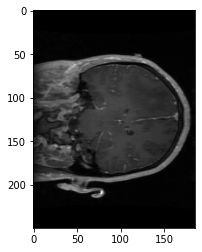

In [536]:
plt.imshow(t1_image_1['t1'].numpy()[0,:,100,:], cmap = 'gray')

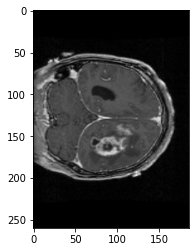

In [535]:
plt.imshow(t1_image_2['t1'].numpy()[0,:,100,:], cmap = 'gray')

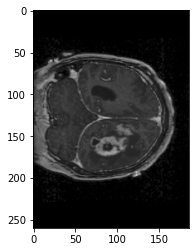

In [537]:
plt.imshow(t1_matched_scimage.reshape(t1_image_2['t1'].numpy()[0,:,100,:].shape), cmap = 'gray')

In [ ]:
### 
dmri = tio.ScalarImage(tensor=torch.rand(32, 128, 128, 88))

In [358]:
import ants
bins = np.arange(0,1, 0.01)
hist_tumor_dataframe = pd.DataFrame(columns = bins)
hist_brain_dataframe = pd.DataFrame(columns = bins)
orig_tumor_dataframe = pd.DataFrame(columns = bins)
orig_brain_dataframe = pd.DataFrame(columns = bins)


mask_dir = '/anvar/public_datasets/preproc_study/gbm/5_ss_shared/'
tumor_mask_path = glob(base_dir + patients[80] + '/CT1_SEG.nii.gz')[0]
brain_mask_path = glob(mask_dir + patients[80] +'/CT1_mask.nii.gz')[0]  

hist_img = t2_normed['t1']
orig_img = t2_image['t1']
tumor_mask = ants.image_read(tumor_mask_path)
brain_mask = ants.image_read(brain_mask_path)

tumor_mask = tumor_mask.numpy() > 0
brain_mask = brain_mask.numpy() > 0
hist_tumor= hist_img.numpy()[0][tumor_mask]
orig_tumor = orig_img.numpy()[0][tumor_mask]

hist_brain = hist_img.numpy()[0][(~tumor_mask)&brain_mask]                 
orig_brain = orig_img.numpy()[0][(~tumor_mask)&brain_mask]  

a_series = pd.Series(np.histogram(hist_tumor, bins = 100)[0], bins )
hist_tumor_dataframe = hist_tumor_dataframe.append(a_series, ignore_index=True)     

b_series = pd.Series(np.histogram(hist_brain, bins = 100)[0], bins )
hist_brain_dataframe = hist_brain_dataframe.append(b_series, ignore_index=True)    

c_series = pd.Series(np.histogram(orig_brain, bins = 100)[0], bins )
orig_brain_dataframe = orig_brain_dataframe.append(c_series, ignore_index=True)    

d_series = pd.Series(np.histogram(orig_tumor, bins = 100)[0], bins )
orig_tumor_dataframe = orig_tumor_dataframe.append(d_series, ignore_index=True)      

In [364]:
hist_brain_dataframe.values[0]

array([37, 32, 88, 224, 346, 463, 545, 620, 742, 836, 910, 994, 1117,
       1217, 1171, 1318, 1420, 1559, 1569, 1644, 1812, 1846, 1915, 2090,
       2070, 2221, 2349, 2441, 2614, 6280, 7900, 8976, 10100, 11593,
       13588, 15498, 17900, 21041, 26507, 39551, 62038, 98938, 139850,
       148877, 74870, 73187, 69109, 63882, 55285, 46008, 37831, 29493,
       22527, 17368, 12914, 9581, 7061, 5170, 4129, 3151, 2531, 2000,
       1586, 1270, 973, 850, 707, 609, 547, 448, 349, 254, 210, 145, 135,
       115, 89, 61, 33, 30, 18, 7, 6, 2, 1, 4, 0, 0, 0, 0, 0, 3, 2, 0, 0,
       0, 0, 0, 1, 1], dtype=object)

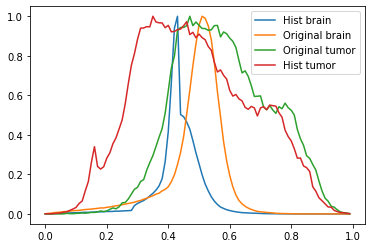

In [367]:
plt.plot(hist_brain_dataframe.columns, hist_brain_dataframe.values[0]/hist_brain_dataframe.values[0].max(), label = 'Hist brain')
plt.plot(hist_brain_dataframe.columns, orig_brain_dataframe.values[0]/orig_brain_dataframe.values[0].max(), label = 'Original brain')
plt.plot(hist_brain_dataframe.columns, orig_tumor_dataframe.values[0]/orig_tumor_dataframe.values[0].max(), label = 'Original tumor')
plt.plot(hist_brain_dataframe.columns, hist_tumor_dataframe.values[0]/hist_tumor_dataframe.values[0].max(), label = 'Hist tumor')
plt.legend();

In [368]:
## t1 

In [369]:
landmarks_dict = {'t1': t2_landmarks}
hist_standardize = tio.HistogramStandardization(landmarks_dict)
t1_normed = hist_standardize(t1_image)

In [370]:
bins = np.arange(0,1, 0.01)
hist_tumor_dataframe = pd.DataFrame(columns = bins)
hist_brain_dataframe = pd.DataFrame(columns = bins)
orig_tumor_dataframe = pd.DataFrame(columns = bins)
orig_brain_dataframe = pd.DataFrame(columns = bins)


mask_dir = '/anvar/public_datasets/preproc_study/gbm/5_ss_shared/'
tumor_mask_path = glob(base_dir + patients[80] + '/CT1_SEG.nii.gz')[0]
brain_mask_path = glob(mask_dir + patients[80] +'/CT1_mask.nii.gz')[0]  

hist_img = t1_normed['t1']
orig_img = t1_image['t1']
tumor_mask = ants.image_read(tumor_mask_path)
brain_mask = ants.image_read(brain_mask_path)

tumor_mask = tumor_mask.numpy() > 0
brain_mask = brain_mask.numpy() > 0
hist_tumor= hist_img.numpy()[0][tumor_mask]
orig_tumor = orig_img.numpy()[0][tumor_mask]

hist_brain = hist_img.numpy()[0][(~tumor_mask)&brain_mask]                 
orig_brain = orig_img.numpy()[0][(~tumor_mask)&brain_mask]  

a_series = pd.Series(np.histogram(hist_tumor, bins = 100)[0], bins )
hist_tumor_dataframe = hist_tumor_dataframe.append(a_series, ignore_index=True)     

b_series = pd.Series(np.histogram(hist_brain, bins = 100)[0], bins )
hist_brain_dataframe = hist_brain_dataframe.append(b_series, ignore_index=True)    

c_series = pd.Series(np.histogram(orig_brain, bins = 100)[0], bins )
orig_brain_dataframe = orig_brain_dataframe.append(c_series, ignore_index=True)    

d_series = pd.Series(np.histogram(orig_tumor, bins = 100)[0], bins )
orig_tumor_dataframe = orig_tumor_dataframe.append(d_series, ignore_index=True)      

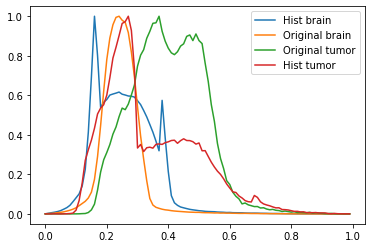

In [371]:
plt.plot(hist_brain_dataframe.columns, hist_brain_dataframe.values[0]/hist_brain_dataframe.values[0].max(), label = 'Hist brain')
plt.plot(hist_brain_dataframe.columns, orig_brain_dataframe.values[0]/orig_brain_dataframe.values[0].max(), label = 'Original brain')
plt.plot(hist_brain_dataframe.columns, orig_tumor_dataframe.values[0]/orig_tumor_dataframe.values[0].max(), label = 'Original tumor')
plt.plot(hist_brain_dataframe.columns, hist_tumor_dataframe.values[0]/hist_tumor_dataframe.values[0].max(), label = 'Hist tumor')
plt.legend();

In [71]:
from torchio.transforms import HistogramStandardization
import argparse
import logging
import mpu.io
from os import path


# parser = argparse.ArgumentParser()

# parser.add_argument('--path', type=str, default='/anvar/public_datasets/preproc_study/bgpd/3a_atlas/', 
#                     help='root dir for subject sequences data')
# parser.add_argument('--fixedfilename', type=list, default=['FLAIR.nii.gz'], help='name of file to register')
# parser.add_argument('--maskfilename', type=list, default=['mask_GTV_FLAIR.nii.gz'], help='name of mask to register to RPI')
# parser.add_argument('--movingfilenames', type=list, default=['CT1.nii.gz','T2.nii.gz','T1.nii.gz'], help='names of files')
# parser.add_argument('--output', type=str, default='/mnt/public_data/preproc_study/bgpd/6_hist/', 
#                     help= 'output folder')
# parser.add_argument('--seed', type=str, default='utils/example.json', help= 'mode individual or shared ')
# parser.add_argument('--device', type=str, default='cpu', help= 'gpu or cpu, if gpu - should be `int` ')

# args = parser.parse_args()
# base_dir = args.path
# save_dir = args.autput
# seed = mpu.io.read(args.seed)
# mask_name = args.maskfilename

base_dir = '/anvar/public_datasets/preproc_study/bgpd/3a_atlas/'
save_dir = '/anvar/public_datasets/preproc_study/bgpd/6_hist/'
seed = mpu.io.read('utils/bgpd_seed.json')
mask_name = 'mask_GTV_FLAIR.nii.gz'


# if __name__ == "__main__":
    
os.makedirs(save_dir, exist_ok=True)
# logging.basicConfig(filename=args.output + "logging.txt", level=logging.INFO, format='[%(asctime)s.%(msecs)03d] %(message)s', datefmt='%Y-%m-%d %H:%M:%S')
# logging.getLogger().addHandler(logging.StreamHandler(sys.stdout))

# Creating a dataset
subjects_list = []
for patient in os.listdir(base_dir):
    if os.path.isdir(base_dir + patient):
        subject = tio.Subject(
            t1 = tio.ScalarImage(base_dir + patient + '/T1.nii.gz'),
            t2 = tio.ScalarImage(base_dir + patient + '/T2.nii.gz'),
            ct1 = tio.ScalarImage(base_dir + patient + '/CT1.nii.gz'),
            fl = tio.ScalarImage(base_dir + patient + '/FLAIR.nii.gz'))

        subjects_list.append(subject)

# Separate dataset for each fold
for fold in ['fold_0', 'fold_1', 'fold_2']:
    print(len(seed[fold]))
#     logging.info(fold, " started.")
    # Create dataset
    temp_t1_list = []
    temp_t2_list = []
    temp_ct1_list = []
    temp_fl_list = []

    for patient in os.listdir(base_dir):
        if patient not in seed[fold]:
            if os.path.isdir(base_dir + patient):
                
                subjects_list.append(subject)
                temp_t1_list.append(base_dir + patient + '/T1.nii.gz')
                temp_t2_list.append(base_dir + patient + '/T2.nii.gz')
                temp_ct1_list.append(base_dir + patient + '/CT1.nii.gz')
                temp_fl_list.append(base_dir + patient + '/FLAIR.nii.gz')

    print('For landmarks there are ', len(temp_t1_list))
    # logging.info("Training T1 landmarks started.")
    t1_landmarks = HistogramStandardization.train(temp_t1_list)
    # logging.info("Training T2 landmarks started.")
    t2_landmarks = HistogramStandardization.train(temp_t2_list)
    # logging.info("Training CT1 landmarks started.")
    ct1_landmarks = HistogramStandardization.train(temp_ct1_list)
    # logging.info("Training FLAIR landmarks started.")
    fl_landmarks = HistogramStandardization.train(temp_fl_list)

    # Saving landmarks
    landmarks_dict = {
    't1': t1_landmarks,
    't2': t2_landmarks,
    'ct1': ct1_landmarks,
    'fl': fl_landmarks
    }

    hist_standardize = tio.HistogramStandardization(landmarks_dict)

        # Apply transforms
    for i in range(0, len(os.listdir(base_dir))):
        # Check if it is logging file instead of a folder
        if os.path.isdir(base_dir + os.listdir(base_dir)[i]):
            os.makedirs(save_dir + '/6_hist_{}/'.format(fold) + os.listdir(base_dir)[i], exist_ok= True)

            if len(os.listdir(save_dir + '/6_hist_{}/'.format(fold) + os.listdir(base_dir)[i])) < 4:
                # logging.info("Saving patient", os.listdir(base_dir)[i], fold)
                hist_standard = hist_standardize(subjects_list[i])
                hist_standard['t1'].save(save_dir + '/6_hist_{}/'.format(fold) + os.listdir(base_dir)[i] +'/T1.nii.gz')
                hist_standard['ct1'].save(save_dir + '/6_hist_{}/'.format(fold) + os.listdir(base_dir)[i] +'/CT1.nii.gz')
                hist_standard['fl'].save(save_dir + '/6_hist_{}/'.format(fold) + os.listdir(base_dir)[i] +'/FLAIR.nii.gz')
                hist_standard['t2'].save(save_dir + '/6_hist_{}/'.format(fold) + os.listdir(base_dir)[i] +'/T2.nii.gz')
                shutil.copy(base_dir + os.listdir(base_dir)[i] + '/' + mask_name,
                save_dir + '/6_hist_{}/'.format(fold) + os.listdir(base_dir)[i] +  '/' + mask_name)

  0%|          | 0/120 [00:00<?, ?it/s]

60
For landmarks there are  120


  0%|          | 0/120 [00:00<?, ?it/s]

60
For landmarks there are  120


  0%|          | 0/120 [00:00<?, ?it/s]

60
For landmarks there are  120


100%|██████████| 120/120 [01:33<00:00,  1.28it/s]


In [78]:
# parser = argparse.ArgumentParser()

# parser.add_argument('--path', type=str, default='/anvar/public_datasets/preproc_study/bgpd/3a_atlas/', 
#                     help='root dir for subject sequences data')
# parser.add_argument('--fixedfilename', type=list, default=['FLAIR.nii.gz'], help='name of file to register')
# parser.add_argument('--maskfilename', type=list, default=['mask_GTV_FLAIR.nii.gz'], help='name of mask to register to RPI')
# parser.add_argument('--movingfilenames', type=list, default=['CT1.nii.gz','T2.nii.gz','T1.nii.gz'], help='names of files')
# parser.add_argument('--output', type=str, default='/mnt/public_data/preproc_study/bgpd/6_hist/', 
#                     help= 'output folder')
# parser.add_argument('--seed', type=str, default='utils/example.json', help= 'mode individual or shared ')
# parser.add_argument('--device', type=str, default='cpu', help= 'gpu or cpu, if gpu - should be `int` ')

# args = parser.parse_args()
# base_dir = args.path
# save_dir = args.autput
# seed = mpu.io.read(args.seed)
# mask_name = args.maskfilename

base_dir = '/anvar/public_datasets/preproc_study/gbm/3a_atlas/'
save_dir = '/anvar/public_datasets/preproc_study/gbm/6_hist/6_histogram/'
seed = mpu.io.read('utils/gbm_seed.json')
mask_name = 'CT1_SEG.nii.gz'


# if __name__ == "__main__":
    
os.makedirs(save_dir, exist_ok=True)
# logging.basicConfig(filename=args.output + "logging.txt", level=logging.INFO, format='[%(asctime)s.%(msecs)03d] %(message)s', datefmt='%Y-%m-%d %H:%M:%S')
# logging.getLogger().addHandler(logging.StreamHandler(sys.stdout))

# Creating a dataset
subjects_list = []
for patient in os.listdir(base_dir):
    if os.path.isdir(base_dir + patient):
        subject = tio.Subject(
            t1 = tio.ScalarImage(base_dir + patient + '/T1.nii.gz'),
            t2 = tio.ScalarImage(base_dir + patient + '/T2.nii.gz'),
            ct1 = tio.ScalarImage(base_dir + patient + '/CT1.nii.gz'),
            fl = tio.ScalarImage(base_dir + patient + '/FLAIR.nii.gz'))

        subjects_list.append(subject)

# Separate dataset for each fold
for fold in ['fold_0', 'fold_1', 'fold_2']:
    print(len(seed[fold]))
#     logging.info(fold, " started.")
    # Create dataset
    temp_t1_list = []
    temp_t2_list = []
    temp_ct1_list = []
    temp_fl_list = []

    for patient in os.listdir(base_dir):
        if patient not in seed[fold]:
            if os.path.isdir(base_dir + patient):
                
                subjects_list.append(subject)
                temp_t1_list.append(base_dir + patient + '/T1.nii.gz')
                temp_t2_list.append(base_dir + patient + '/T2.nii.gz')
                temp_ct1_list.append(base_dir + patient + '/CT1.nii.gz')
                temp_fl_list.append(base_dir + patient + '/FLAIR.nii.gz')

    print('For landmarks there are ', len(temp_t1_list))
    # logging.info("Training T1 landmarks started.")
    t1_landmarks = HistogramStandardization.train(temp_t1_list)
    # logging.info("Training T2 landmarks started.")
    t2_landmarks = HistogramStandardization.train(temp_t2_list)
    # logging.info("Training CT1 landmarks started.")
    ct1_landmarks = HistogramStandardization.train(temp_ct1_list)
    # logging.info("Training FLAIR landmarks started.")
    fl_landmarks = HistogramStandardization.train(temp_fl_list)

    # Saving landmarks
    landmarks_dict = {
    't1': t1_landmarks,
    't2': t2_landmarks,
    'ct1': ct1_landmarks,
    'fl': fl_landmarks
    }

    hist_standardize = tio.HistogramStandardization(landmarks_dict)

        # Apply transforms
    for i in range(0, len(os.listdir(base_dir))):
        # Check if it is logging file instead of a folder
        if os.path.isdir(base_dir + os.listdir(base_dir)[i]):
            os.makedirs(save_dir + '/6_hist_{}/'.format(fold) + os.listdir(base_dir)[i], exist_ok= True)

            if len(os.listdir(save_dir + '/6_hist_{}/'.format(fold) + os.listdir(base_dir)[i])) < 5:
                print(os.listdir(base_dir)[i])
                # logging.info("Saving patient", os.listdir(base_dir)[i], fold)
                hist_standard = hist_standardize(subjects_list[i])
                hist_standard['t1'].save(save_dir + '/6_hist_{}/'.format(fold) + os.listdir(base_dir)[i] +'/T1.nii.gz')
                hist_standard['ct1'].save(save_dir + '/6_hist_{}/'.format(fold) + os.listdir(base_dir)[i] +'/CT1.nii.gz')
                hist_standard['fl'].save(save_dir + '/6_hist_{}/'.format(fold) + os.listdir(base_dir)[i] +'/FLAIR.nii.gz')
                hist_standard['t2'].save(save_dir + '/6_hist_{}/'.format(fold) + os.listdir(base_dir)[i] +'/T2.nii.gz')
                shutil.copy(base_dir + os.listdir(base_dir)[i] + '/' + mask_name,
                save_dir + '/6_hist_{}/'.format(fold) + os.listdir(base_dir)[i] +  '/' + mask_name)

  0%|          | 0/68 [00:00<?, ?it/s]

34
For landmarks there are  68


100%|██████████| 68/68 [00:33<00:00,  2.05it/s]


TCGA-06-0142
TCGA-02-0037


  0%|          | 0/68 [00:00<?, ?it/s]

34
For landmarks there are  68


100%|██████████| 68/68 [00:35<00:00,  1.90it/s]


TCGA-06-0142
TCGA-02-0037
TCGA-08-0520


  0%|          | 0/68 [00:00<?, ?it/s]

34
For landmarks there are  68


100%|██████████| 68/68 [00:33<00:00,  2.04it/s]


TCGA-06-0142
TCGA-02-0037
TCGA-08-0520


In [79]:
# cheching packages
for fold in ['fold_0', 'fold_1', 'fold_2']:
    print( fold, len(os.listdir(save_dir + '/6_hist_{}/'.format(fold))))
    for patient in os.listdir(base_dir):
        try:
            print(len(os.listdir(save_dir + '/6_hist_{}/'.format(fold) + patient )) == 5)
        except:
            print(patient)
            pass

fold_0 102
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
logging.txt
True
True
True
fold_1 102
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
T

## Checking distributions

In [137]:
os.listdir(save_dir)

['6_hist_fold_1',
 '6_hist_gbm',
 '6_hist_fold_2',
 '6_hist_fold_0',
 'logging.txt']

In [151]:
os.listdir('/anvar/public_datasets/preproc_study/lgg/5_ss_shared/TCGA-CS-6188')

['T2.nii.gz',
 'FLAIR.nii.gz',
 'T1.nii.gz',
 'CT1_SEG.nii.gz',
 'CT1_mask.nii.gz',
 'CT1.nii.gz']

In [152]:
mask_dir = '/anvar/public_datasets/preproc_study/lgg/5_ss_shared/'

In [144]:
base_dir

'/anvar/public_datasets/preproc_study/lgg/4a_resamp/'

In [141]:
import pandas as pd
bins = np.arange(0,1, 0.01)

In [163]:
ds = 'lgg'
mask_dir = '/anvar/public_datasets/preproc_study/{}/5_ss_shared/'.format(ds)
base_dir = '/anvar/public_datasets/preproc_study/{}/4a_resamp/'.format(ds)
save_dir = '/anvar/public_datasets/preproc_study/{}/6_hist/'.format(ds)

In [164]:
hist_tumor_dataframe = pd.DataFrame(columns = bins)
hist_brain_dataframe = pd.DataFrame(columns = bins)
orig_tumor_dataframe = pd.DataFrame(columns = bins)
orig_brain_dataframe = pd.DataFrame(columns = bins)

for fold in ['gbm']:
    for patient in os.listdir(base_dir):
        if os.path.isdir(base_dir + patient):
#             print(patient)
            hist_img_path = glob(save_dir + '/6_hist_{}/'.format(fold) + patient +'/CT1.nii.gz')[0]
            orig_img_path = glob(base_dir + patient + '/CT1.nii.gz')[0]
            tumor_mask_path = glob(base_dir + patient + '/CT1_SEG.nii.gz')[0]
            brain_mask_path = glob(mask_dir + patient +'/CT1_mask.nii.gz')[0]   

            hist_img = ants.image_read(hist_img_path)
            orig_img = ants.image_read(orig_img_path)
            tumor_mask = ants.image_read(tumor_mask_path)
            brain_mask = ants.image_read(brain_mask_path)

            tumor_mask = tumor_mask.numpy() > 0
            brain_mask = brain_mask.numpy() > 0
            hist_tumor= hist_img.numpy()[tumor_mask]
            orig_tumor = orig_img.numpy()[tumor_mask]

            hist_brain = hist_img.numpy()[(~tumor_mask)&brain_mask]                 
            orig_brain = orig_img.numpy()[(~tumor_mask)&brain_mask]  

            a_series = pd.Series(np.histogram(hist_tumor, bins = 100, normed =True)[0], bins )
            hist_tumor_dataframe = hist_tumor_dataframe.append(a_series, ignore_index=True)     

            b_series = pd.Series(np.histogram(hist_brain, bins = 100, normed =True)[0], bins )
            hist_brain_dataframe = hist_brain_dataframe.append(b_series, ignore_index=True)    

            c_series = pd.Series(np.histogram(orig_brain, bins = 100, normed =True)[0], bins )
            orig_brain_dataframe = orig_brain_dataframe.append(c_series, ignore_index=True)    

            d_series = pd.Series(np.histogram(orig_tumor, bins = 100, normed =True)[0], bins )
            orig_tumor_dataframe = orig_tumor_dataframe.append(d_series, ignore_index=True)      

/tmp/ipykernel_176129/3221308365.py:28: VisibleDeprecationWarning:

Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.

/tmp/ipykernel_176129/3221308365.py:31: VisibleDeprecationWarning:

Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.

/tmp/ipykernel_176129/3221308365.py:34: VisibleDeprecationWarning:

Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass functio

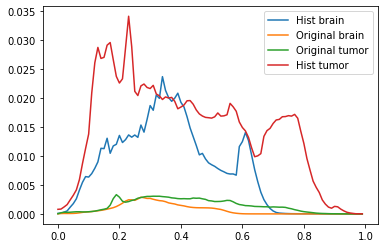

In [165]:
plt.plot(hist_brain_dataframe.columns, hist_brain_dataframe.std(), label = 'Hist brain')
plt.plot(hist_brain_dataframe.columns, orig_brain_dataframe.std(), label = 'Original brain')
plt.plot(hist_brain_dataframe.columns, orig_tumor_dataframe.std(), label = 'Original tumor')
plt.plot(hist_brain_dataframe.columns, hist_tumor_dataframe.std(), label = 'Hist tumor')
plt.legend();

In [166]:
ds = 'gbm'
mask_dir = '/anvar/public_datasets/preproc_study/{}/5_ss_shared/'.format(ds)
base_dir = '/anvar/public_datasets/preproc_study/{}/4a_resamp/'.format(ds)
save_dir = '/anvar/public_datasets/preproc_study/{}/6_hist/'.format(ds)

In [167]:
hist_tumor_dataframe = pd.DataFrame(columns = bins)
hist_brain_dataframe = pd.DataFrame(columns = bins)
orig_tumor_dataframe = pd.DataFrame(columns = bins)
orig_brain_dataframe = pd.DataFrame(columns = bins)

for fold in ['fold_1']:
    for patient in os.listdir(base_dir):
        if os.path.isdir(base_dir + patient):
#             print(patient)
            hist_img_path = glob(save_dir + '/6_hist_{}/'.format(fold) + patient +'/CT1.nii.gz')[0]
            orig_img_path = glob(base_dir + patient + '/CT1.nii.gz')[0]
            tumor_mask_path = glob(base_dir + patient + '/CT1_SEG.nii.gz')[0]
            brain_mask_path = glob(mask_dir + patient +'/CT1_mask.nii.gz')[0]   

            hist_img = ants.image_read(hist_img_path)
            orig_img = ants.image_read(orig_img_path)
            tumor_mask = ants.image_read(tumor_mask_path)
            brain_mask = ants.image_read(brain_mask_path)

            tumor_mask = tumor_mask.numpy() > 0
            brain_mask = brain_mask.numpy() > 0
            hist_tumor= hist_img.numpy()[tumor_mask]
            orig_tumor = orig_img.numpy()[tumor_mask]

            hist_brain = hist_img.numpy()[(~tumor_mask)&brain_mask]                 
            orig_brain = orig_img.numpy()[(~tumor_mask)&brain_mask]  

            a_series = pd.Series(np.histogram(hist_tumor, bins = 100, normed =True)[0], bins )
            hist_tumor_dataframe = hist_tumor_dataframe.append(a_series, ignore_index=True)     

            b_series = pd.Series(np.histogram(hist_brain, bins = 100, normed =True)[0], bins )
            hist_brain_dataframe = hist_brain_dataframe.append(b_series, ignore_index=True)    

            c_series = pd.Series(np.histogram(orig_brain, bins = 100, normed =True)[0], bins )
            orig_brain_dataframe = orig_brain_dataframe.append(c_series, ignore_index=True)    

            d_series = pd.Series(np.histogram(orig_tumor, bins = 100, normed =True)[0], bins )
            orig_tumor_dataframe = orig_tumor_dataframe.append(d_series, ignore_index=True)      

/tmp/ipykernel_176129/2214720100.py:28: VisibleDeprecationWarning:

Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.

/tmp/ipykernel_176129/2214720100.py:31: VisibleDeprecationWarning:

Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.

/tmp/ipykernel_176129/2214720100.py:34: VisibleDeprecationWarning:

Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass functio

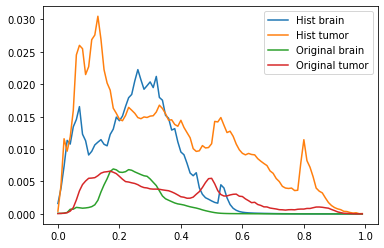

In [202]:
plt.set_cmap('viridis')
plt.plot(hist_brain_dataframe.columns, hist_brain_dataframe.std(), label = 'Hist brain')
plt.plot(hist_brain_dataframe.columns, hist_tumor_dataframe.std(), label = 'Hist tumor')
plt.plot(hist_brain_dataframe.columns, orig_brain_dataframe.std(), label = 'Original brain')
plt.plot(hist_brain_dataframe.columns, orig_tumor_dataframe.std(), label = 'Original tumor')
plt.legend();

### Check 1 patient before and after

# 1. GBM and LGG hist dataset

1. check histograms on LGG and on GBM
2. train on GBM transform histograms

In [203]:
base_dir = '/anvar/public_datasets/preproc_study/gbm/4a_resamp/'
save_dir = '/anvar/public_datasets/preproc_study/lgg/6_hist/6_hist_gbm/'
mask_name = 'CT1_SEG.nii.gz'

In [204]:
fold = 'fold_2'

In [205]:
from torchio.transforms import HistogramStandardization
from tqdm import tqdm

# Separate dataset for each fold
# Create dataset
temp_t1_list = []
temp_t2_list = []
temp_ct1_list = []
temp_fl_list = []

for patient in os.listdir(base_dir):
    if patient not in gbm_seed[fold]:
        if os.path.isdir(base_dir + patient):
            temp_t1_list.append(base_dir + patient + '/T1.nii.gz')
            temp_t2_list.append(base_dir + patient + '/T2.nii.gz')
            temp_ct1_list.append(base_dir + patient + '/CT1.nii.gz')
            temp_fl_list.append(base_dir + patient + '/FLAIR.nii.gz')
#             print(len(subjects_list))

print('For landmarks there are ', len(temp_t1_list))
# logging.info("Training T1 landmarks started.")
t1_landmarks = HistogramStandardization.train(temp_t1_list)
# logging.info("Training T2 landmarks started.")
t2_landmarks = HistogramStandardization.train(temp_t2_list)
# logging.info("Training CT1 landmarks started.")
ct1_landmarks = HistogramStandardization.train(temp_ct1_list)
# logging.info("Training FLAIR landmarks started.")
fl_landmarks = HistogramStandardization.train(temp_fl_list)

# Saving landmarks
landmarks_dict = {
't1': t1_landmarks,
't2': t2_landmarks,
'ct1': ct1_landmarks,
'fl': fl_landmarks
}

hist_standardize = tio.HistogramStandardization(landmarks_dict)

  0%|          | 0/68 [00:00<?, ?it/s]

For landmarks there are  68


100%|██████████| 68/68 [00:48<00:00,  1.42it/s]


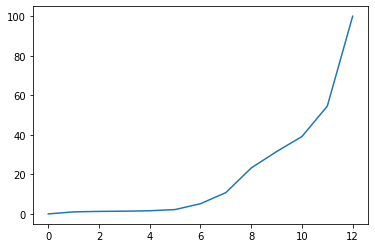

In [212]:
plt.plot(landmarks_dict['t1'])

In [221]:
orig_img_path = glob(base_dir + patient + '/CT1.nii.gz')[0]
orig_img_path

'/anvar/public_datasets/preproc_study/gbm/4a_resamp/TCGA-08-0520/CT1.nii.gz'

In [215]:
t1 = tio.ScalarImage(orig_img_path)

In [220]:
(t1.numpy()).dtype

dtype('float32')

In [228]:
hist

array([9627692, 2144310,  623771,  151358,   20704,    4082,    1046,
           390,     157,      58,      16,      13,       3])

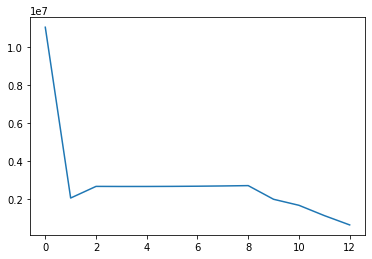

In [235]:
hist_before = np.histogram(np.nonzero(t1.numpy()), bins = 13)[0]
plt.plot(hist_before)

In [232]:
path_after = '/anvar/public_datasets/preproc_study/gbm/6_hist/6_hist_fold_1/TCGA-08-0520/CT1.nii.gz'
t1_after = tio.ScalarImage(path_after)

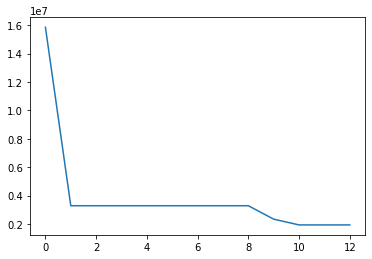

In [234]:
hist_after = np.histogram(np.nonzero(t1_after.numpy()), bins = 13)[0]
plt.plot(hist_after)

In [ ]:
1. посмотреть как строится cdf
2. сделать менчинг t1 на  t2. С маской или без маски
3. посмотреть как они делают otsu thresholding (наложить маску)
4. 

In [ ]:
orig_img_path = glob(base_dir + patient + '/CT1.nii.gz')[0]
orig_img_path

In [196]:
# Creating a dataset
subjects_list = []
os.makedirs(save_dir + '/6_hist_gbm_{}/'.format(fold), exist_ok=True)

for patient in tqdm(os.listdir(base_dir)):
    if os.path.isdir(base_dir + patient):
        subject = tio.Subject(
            t1 = tio.ScalarImage(base_dir + patient + '/T1.nii.gz'),
            t2 = tio.ScalarImage(base_dir + patient + '/T2.nii.gz'),
            # can be commented for other datasets
            ct1 = tio.ScalarImage(base_dir + patient + '/CT1.nii.gz'),
            fl = tio.ScalarImage(base_dir + patient + '/FLAIR.nii.gz')
        )
        subjects_list.append(subject)
        
        # hist standartize for the four landmarks
        hist_standard = hist_standardize(subject)
        try:
            os.mkdir(save_dir + '/6_hist_gbm_{}/'.format(fold)+ patient)
        except:
            pass
        hist_standard['t1'].save(save_dir + '/6_hist_gbm_{}/'.format(fold) + patient +'/T1.nii.gz')
        hist_standard['t2'].save(save_dir + '/6_hist_gbm_{}/'.format(fold) + patient +'/T2.nii.gz')
        # can be commented for other datasets
        hist_standard['ct1'].save(save_dir + '/6_hist_gbm_{}/'.format(fold) + patient +'/CT1.nii.gz')
        hist_standard['fl'].save(save_dir + '/6_hist_gbm_{}/'.format(fold) + patient +'/FLAIR.nii.gz')
        # saving segmentation file
        shutil.copy(base_dir + patient + '/' + mask_name,
                save_dir + '/6_hist_gbm_{}/'.format(fold) + patient +  '/' +  mask_name)

100%|██████████| 39/39 [06:04<00:00,  9.36s/it]


In [ ]:
# creating a list for lgg
save_dir = '/anvar/public_datasets/preproc_study/lgg/6_hist/'
base_dir = '/anvar/public_datasets/preproc_study/lgg/4a_resamp/'

subjects_list = []
for patient in os.listdir(base_dir):
    if os.path.isdir(base_dir + patient):
        subjects_list.append(patient)
        temp_t1_list.append(base_dir + patient + '/T1.nii.gz')
        temp_t2_list.append(base_dir + patient + '/T2.nii.gz')
        temp_ct1_list.append(base_dir + patient + '/CT1.nii.gz')
        temp_fl_list.append(base_dir + patient + '/FLAIR.nii.gz')
print(len(subjects_list))

In [113]:
for i in tqdm(range(0, len(subjects_list))):
            # Check if it is logging file instead of a folder
    if os.path.isdir(base_dir + subjects_list[i]):
        os.makedirs(save_dir + '/6_hist_gbm/' + subjects_list[i], exist_ok= True)

        if len(os.listdir(save_dir + '/6_hist_gbm/' + subjects_list[i])) < 4:
            subject = tio.Subject(
                t1 = tio.ScalarImage(base_dir + patient + '/T1.nii.gz'),
                t2 = tio.ScalarImage(base_dir + patient + '/T2.nii.gz'),
                # can be commented for other datasets
                ct1 = tio.ScalarImage(base_dir + patient + '/CT1.nii.gz'),
                fl = tio.ScalarImage(base_dir + patient + '/FLAIR.nii.gz')
            )

            # hist standartize for the four landmarks
            hist_standard = hist_standardize(subjects_list[i])

            hist_standard['t1'].save(save_dir + '/6_hist_gbm/'+ subjects_list[i] +'/T1.nii.gz')
            hist_standard['t2'].save(save_dir + '/6_hist_gbm/' + subjects_list[i] +'/T2.nii.gz')
            # can be commented for other datasets
            hist_standard['ct1'].save(save_dir + '/6_hist_gbm/' + subjects_list[i] +'/CT1.nii.gz')
            hist_standard['fl'].save(save_dir + '/6_hist_gbm/' + subjects_list[i] +'/FLAIR.nii.gz')
            # saving segmentation file
            shutil.copy(base_dir + subjects_list[i] + '/' + mask_name,
                    save_dir + '/6_hist_gbm/' + subjects_list[i] +  '/' +  mask_name)

  0%|          | 0/38 [00:00<?, ?it/s]

TCGA-CS-6188


ValueError: Input type not recognized: <class 'str'>

In [90]:
shutil.copy(base_dir + os.listdir(base_dir)[i] + '/' + mask_name, 
            save_dir + '/6_hist_gbm/' + os.listdir(base_dir)[i] +  '/' +  mask_name)

'/anvar/public_datasets/preproc_study/lgg/6_hist//6_hist_gbm/TCGA-DU-7014/CT1_SEG.nii.gz'

In [94]:
ants.image_read(base_dir + os.listdir(base_dir)[i] + '/' + mask_name)

ANTsImage (RPI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (240, 240, 180)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (-120.0, 359.19, -110.0)
	 Direction  : [ 1.  0.  0.  0. -1.  0.  0.  0.  1.]

In [96]:
ants.image_read(output + patient +'/CT1.nii.gz')

ANTsImage (RPI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (260, 260, 186)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (-128.0, 132.7844, -107.0)
	 Direction  : [ 1.  0.  0.  0. -1.  0.  0.  0.  1.]

In [ ]:
ants.image_read(base_dir + os.listdir(base_dir)[i] + '/' + mask_name)

In [85]:
def plot_qc_show(image, mask, patient_id):
    fig, axs = plt.subplots(3,3,figsize=(12,12))
    idx = np.argsort(mask.sum(axis=(0,1)))[-3:]
    for i in range(3):
        axs[i, 0].imshow(image[..., idx[i]], cmap='gray')
        axs[i, 1].imshow(mask[..., idx[i]], cmap='gray')
        axs[i, 2].imshow(image[..., idx[i]]+200*mask[..., idx[i]], cmap='gray')
    axs[0,0].set_title(patient_id)
    plt.tight_layout()
    plt.show()

In [86]:
list_subjs = os.listdir('/anvar/public_datasets/preproc_study/lgg/orig/')

In [135]:
os.listdir(save_dir)

['6_hist_fold_1',
 '6_hist_gbm',
 '6_hist_fold_2',
 '6_hist_fold_0',
 'logging.txt']

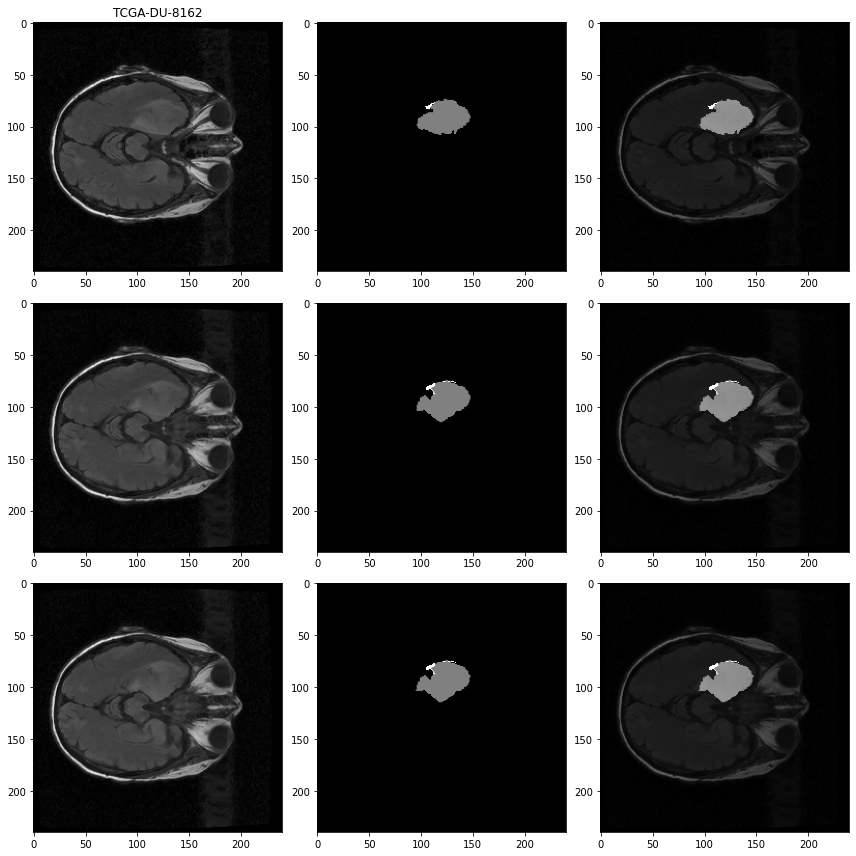

In [131]:
path = '6_hist/6_hist_gbm/'
output = '/anvar/public_datasets/preproc_study/lgg/{}/'.format(path)

patient = list_subjs[11]
im = ants.image_read(output + patient +'/FLAIR.nii.gz')
mask = ants.image_read(output + patient +'/CT1_SEG.nii.gz')
plot_qc_show(im, mask, patient_id=str(patient))

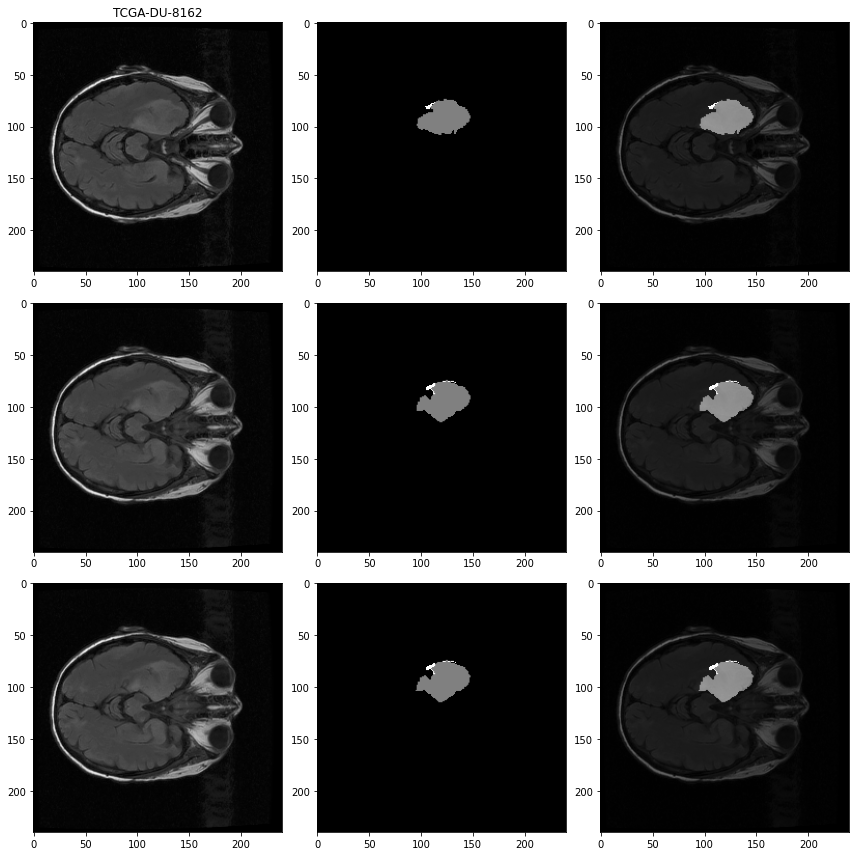

In [130]:
path = '6_hist/6_hist_fold_1/'
output = '/anvar/public_datasets/preproc_study/lgg/{}/'.format(path)

patient = list_subjs[11]
im = ants.image_read(output + patient +'/FLAIR.nii.gz')
mask = ants.image_read(output + patient +'/CT1_SEG.nii.gz')
plot_qc_show(im, mask, patient_id=str(patient))